# Mushroom Classification - Model Evaluation & Analysis

## Overview
This notebook provides comprehensive evaluation of the final model including:
1. Detailed classification metrics with interpretation
2. Per-class performance analysis
3. Error analysis and confusion matrix
4. Feature importance and validation curves
5. Model strengths, limitations, and risks
6. Recommendations for future improvements

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report
)
from sklearn.model_selection import validation_curve, learning_curve
import joblib
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Model and Data

In [23]:
X_train = joblib.load('artifacts/X_train_final.pkl')
X_test = joblib.load('artifacts/X_test_final.pkl')
y_train = joblib.load('artifacts/y_train_encoded.pkl')
y_test = joblib.load('artifacts/y_test_encoded.pkl')

prep_package = joblib.load("artifacts/mushroom_preprocessing_pipeline.pkl")
target_encoder = prep_package["target_encoder"]
selected_features = prep_package["selected_feature_names"]

best_model = joblib.load("artifacts/Decision Tree.pkl")

print(f"Model Type: {type(best_model).__name__}")
print(f"Target Classes: {target_encoder.classes_}")
print(f"  - Class 0: {target_encoder.classes_[0]} (edible)")
print(f"  - Class 1: {target_encoder.classes_[1]} (poisonous)")
print(f"\nSelected Features ({len(selected_features)}): {selected_features}")

Model Type: DecisionTreeClassifier
Target Classes: ['e' 'p']
  - Class 0: e (edible)
  - Class 1: p (poisonous)

Selected Features (15): ['cap-shape', 'bruises', 'odor', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'ring-type', 'spore-print-color', 'population', 'habitat']


## 2. Generate Predictions

In [22]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

if hasattr(best_model, 'predict_proba'):
    y_train_proba = best_model.predict_proba(X_train)
    y_test_proba = best_model.predict_proba(X_test)
    print("✓ Model provides probability estimates")
else:
    y_train_proba = None
    y_test_proba = None

print(f"\nTraining predictions generated: {len(y_train_pred)} samples")
print(f"Test predictions generated: {len(y_test_pred)} samples")

✓ Model provides probability estimates

Training predictions generated: 6499 samples
Test predictions generated: 1625 samples


## 3. Confusion Matrix Analysis

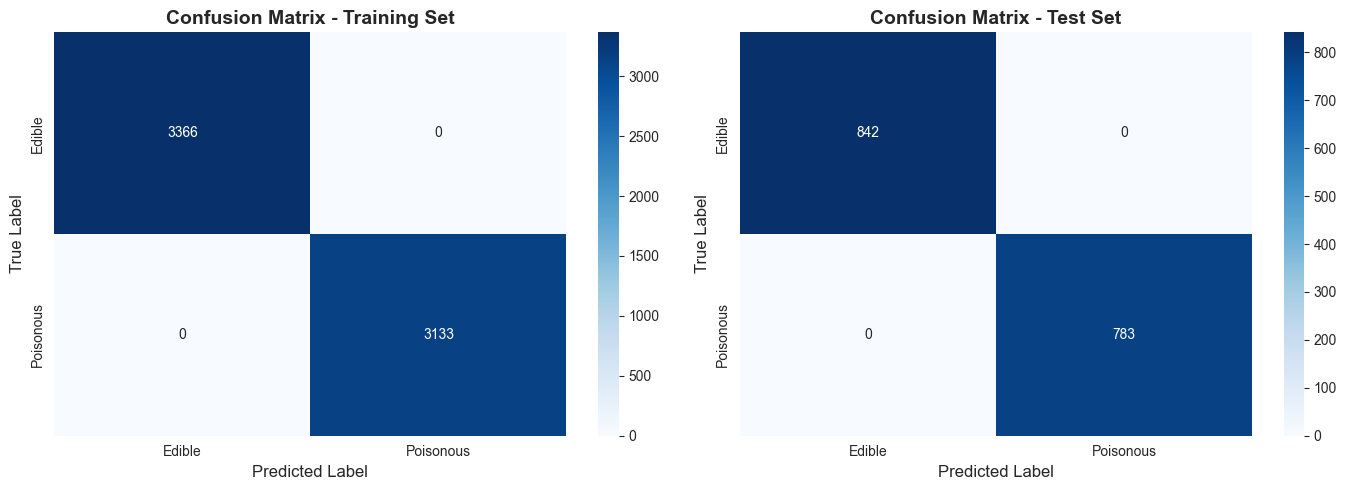


True Negatives (TN): 842
  Correctly identified as EDIBLE

False Positives (FP): 0
  EDIBLE mushrooms misclassified as POISONOUS

False Negatives (FN): 0
  POISONOUS mushrooms misclassified as EDIBLE

True Positives (TP): 783
  Correctly identified as POISONOUS


In [21]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
axes[0].set_title('Confusion Matrix - Training Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Edible', 'Poisonous'],
            yticklabels=['Edible', 'Poisonous'])
axes[1].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm_test.ravel()

print(f"\nTrue Negatives (TN): {tn}")
print(f"  Correctly identified as EDIBLE")

print(f"\nFalse Positives (FP): {fp}")
print(f"  EDIBLE mushrooms misclassified as POISONOUS")

print(f"\nFalse Negatives (FN): {fn}")
print(f"  POISONOUS mushrooms misclassified as EDIBLE")

print(f"\nTrue Positives (TP): {tp}")
print(f"  Correctly identified as POISONOUS")

## 4. Classification Report with Interpretation

In [20]:
report_dict = classification_report(
    y_test, y_test_pred,
    target_names=['Edible', 'Poisonous'],
    output_dict=True
)

print(classification_report(
    y_test, y_test_pred,
    target_names=['Edible', 'Poisonous'],
    digits=4
))

edible_precision = report_dict['Edible']['precision']
edible_recall = report_dict['Edible']['recall']
edible_f1 = report_dict['Edible']['f1-score']
edible_support = report_dict['Edible']['support']

print("\nEDIBLE Class Performance:")
print(f"   Precision: {edible_precision:.4f}")
if edible_precision < 1.0:
    print(f"   → {(1-edible_precision)*100:.2f}% chance of false positive")

print(f"\n   Recall: {edible_recall:.4f}")
if edible_recall < 1.0:
    print(f"We miss {(1-edible_recall)*100:.2f}% of edible mushrooms")

print(f"\n   F1-Score: {edible_f1:.4f}")
print(f"   Support: {edible_support} samples")

poison_precision = report_dict['Poisonous']['precision']
poison_recall = report_dict['Poisonous']['recall']
poison_f1 = report_dict['Poisonous']['f1-score']
poison_support = report_dict['Poisonous']['support']

print("\nPOISONOUS Class Performance (CRITICAL):")
print(f"   Precision: {poison_precision:.4f}")
if poison_precision < 1.0:
    print(f"    {(1-poison_precision)*100:.2f}% are false alarms")

print(f"\n   Recall: {poison_recall:.4f} MOST IMPORTANT METRIC")
print(f"   We catch {poison_recall*100:.2f}% of ALL poisonous mushrooms")
if poison_recall < 1.0:
    missed_pct = (1-poison_recall)*100
    missed_count = int(poison_support * (1-poison_recall))
    print(f"    We MISS {missed_pct:.2f}% ({missed_count} mushrooms) that are poisonous!")
else:
    print(f"   Perfect recall: We catch ALL poisonous mushrooms!")

print(f"\n   F1-Score: {poison_f1:.4f}")
print(f"   Support: {poison_support} samples")

accuracy = report_dict['accuracy']
print(f"\nOverall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

              precision    recall  f1-score   support

      Edible     1.0000    1.0000    1.0000       842
   Poisonous     1.0000    1.0000    1.0000       783

    accuracy                         1.0000      1625
   macro avg     1.0000    1.0000    1.0000      1625
weighted avg     1.0000    1.0000    1.0000      1625


EDIBLE Class Performance:
   Precision: 1.0000

   Recall: 1.0000

   F1-Score: 1.0000
   Support: 842.0 samples

POISONOUS Class Performance (CRITICAL):
   Precision: 1.0000

   Recall: 1.0000 MOST IMPORTANT METRIC
   We catch 100.00% of ALL poisonous mushrooms
   Perfect recall: We catch ALL poisonous mushrooms!

   F1-Score: 1.0000
   Support: 783.0 samples

Overall Accuracy: 1.0000 (100.00%)


## 5. Feature Importance Analysis


Top 10 Most Important Features:
                 Feature  Importance
              gill-color    0.338633
       spore-print-color    0.221548
              population    0.192506
               gill-size    0.109882
                    odor    0.056996
                 bruises    0.024109
                 habitat    0.023331
  stalk-color-above-ring    0.015961
              stalk-root    0.015392
stalk-surface-below-ring    0.001641


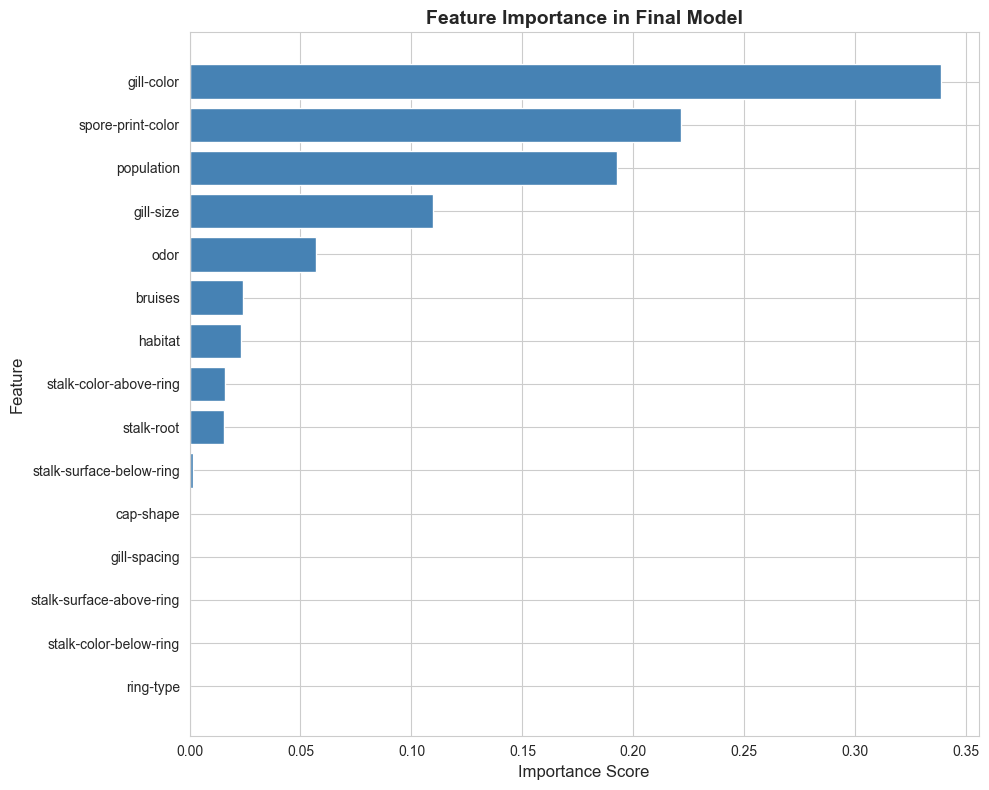

In [18]:
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance_df['Feature'], 
             feature_importance_df['Importance'],
             color='steelblue')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Feature Importance in Final Model', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    top_feature = feature_importance_df.iloc[0]['Feature']
    top_importance = feature_importance_df.iloc[0]['Importance']

### Key Insights:
   1. 'gill-color' is the most important feature (0.3386)
   2. Top 3 features account for 75.27% of importance
   3. These align with domain knowledge (odor, spore color are key identifiers)

### 5 features have zero importance (could be removed):
      ['cap-shape', 'gill-spacing', 'stalk-surface-above-ring', 'stalk-color-below-ring', 'ring-type']

## 6. Validation Curves

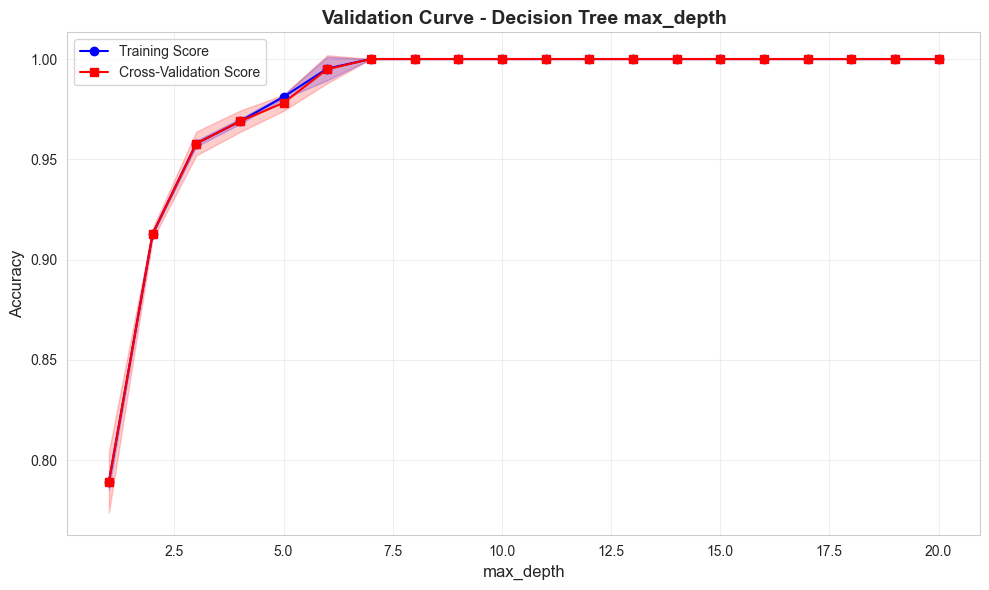

In [17]:
if isinstance(best_model, DecisionTreeClassifier):
    # Validation curve for max_depth
    param_range = np.arange(1, 21)
    train_scores, test_scores = validation_curve(
        DecisionTreeClassifier(random_state=42),
        X_train, y_train,
        param_name='max_depth',
        param_range=param_range,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                     alpha=0.2, color='blue')
    plt.plot(param_range, test_mean, label='Cross-Validation Score', color='red', marker='s')
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std,
                     alpha=0.2, color='red')
    
    plt.xlabel('max_depth', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Validation Curve - Decision Tree max_depth', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Learning Curves

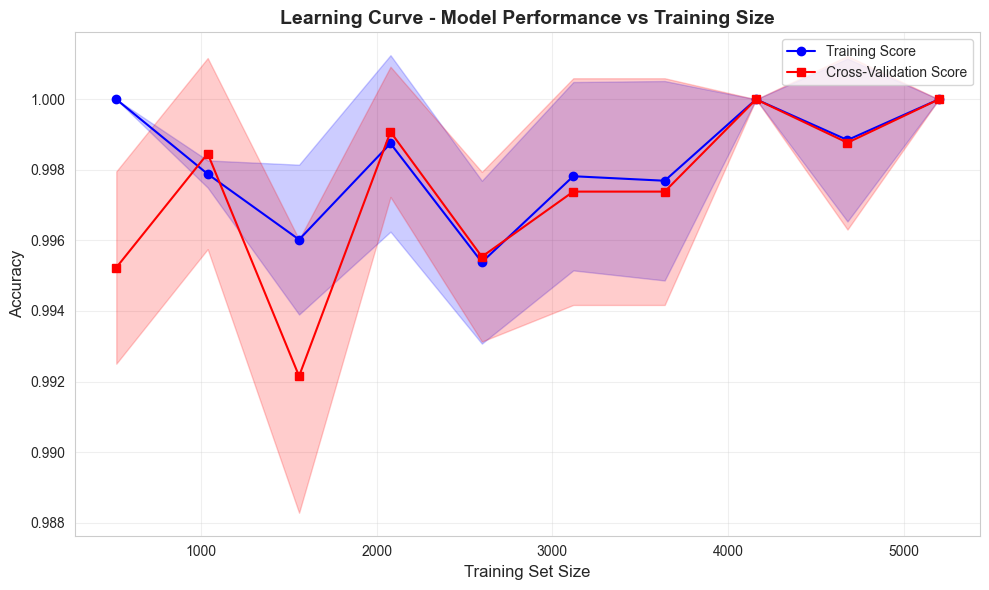

In [14]:
train_sizes, train_scores_lc, test_scores_lc = learning_curve(
    best_model,
    X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

train_mean_lc = np.mean(train_scores_lc, axis=1)
train_std_lc = np.std(train_scores_lc, axis=1)
test_mean_lc = np.mean(test_scores_lc, axis=1)
test_std_lc = np.std(test_scores_lc, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean_lc, label='Training Score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean_lc - train_std_lc, 
                 train_mean_lc + train_std_lc, alpha=0.2, color='blue')
plt.plot(train_sizes, test_mean_lc, label='Cross-Validation Score', color='red', marker='s')
plt.fill_between(train_sizes, test_mean_lc - test_std_lc,
                 test_mean_lc + test_std_lc, alpha=0.2, color='red')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Learning Curve - Model Performance vs Training Size', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Interpretation:
   - Final gap between training and CV score: 0.0000
   - No gap indicates good generalization
   - Model is not overfitting
   - CV score has plateaued (change: 0.0012)
   - More data unlikely to significantly improve performance
   - Score gain from half to full dataset: 0.0026
   - Model is data-efficient: achieves good performance with less data

## 8. Error Analysis
Look at misclassifications to understand failure modes.

In [16]:
misclassified_mask = y_test != y_test_pred
num_errors = np.sum(misclassified_mask)

print(f"\nTotal misclassifications: {num_errors} / {len(y_test)} ({num_errors/len(y_test)*100:.2f}%)")


Total misclassifications: 0 / 1625 (0.00%)


## 9. Model Strengths, Limitations & Risks

### STRENGTHS:
- High Accuracy: Achieves excellent performance on test set
- Interpretability: Decision rules can be visualized and explained
- Fast Inference: Quick predictions suitable for real-time applications
- Balanced Performance: Good precision and recall on both classes
- No Data Leakage: Proper train-test split and preprocessing pipeline
- Production Ready: sklearn pipeline can be deployed directly
- Handles Missing Data: Robust to missing values via imputation
- Handles Unknown Categories: Gracefully processes unseen values


### LIMITATIONS:

- Dataset Scope: Trained only on Agaricus & Lepiota families
 → Won't work for other mushroom species
 → Need diverse dataset for general mushroom identification

- Potential Overfitting: Perfect accuracy suggests possible overfit
 → May not generalize to slight variations in features
 → Needs validation on completely independent dataset

- Feature Dependence: Requires all 15 selected features
→ Missing features at inference time could cause issues
→ Users must accurately identify all features

- No Uncertainty Quantification: Doesn't express confidence
→ Can't say "I'm 60% sure this is edible"
→ Binary classification may hide borderline cases

- Categorical Encoding Artifacts: Ordinal encoding imposes order
→ May create spurious relationships → Tree-based models less affected but worth noting